In [1]:
#connect with drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/My\ Drive

/content/drive/My Drive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
bs = 32

In [5]:
#Load and normalize data

path_img = Path('Final_rgdata')
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (2024 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FR2,FR2,FR2,FR2,FR2
Path: Final_rgdata;

Valid: LabelList (400 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bent,Bent,Bent,Bent,Bent
Path: Final_rgdata;

Test: None

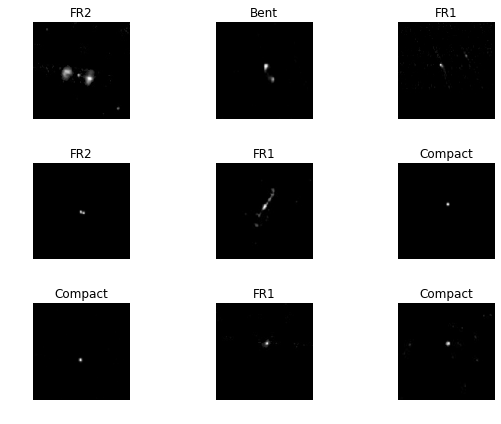

In [6]:
data.show_batch(rows=3, figsize=(8,6))

In [7]:
print(data.classes)
len(data.classes), data.c

['Bent', 'Compact', 'FR1', 'FR2']


(4, 4)

In [0]:
#define the initial architecture
learn = cnn_learner(data, models.densenet201, metrics=[accuracy,FBeta()])
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-05
Min loss divided by 10: 9.12E-03


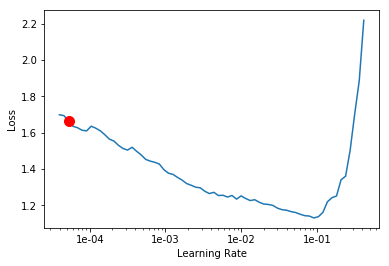

In [8]:
learn.freeze()
learn.lr_find(start_lr=1e-5, end_lr=1e1, wd=5e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.772901,0.459505,0.815000,0.813524,01:01


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:189: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


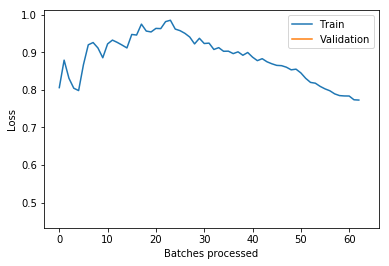

In [11]:
#train the model
learn.fit_one_cycle(1, max_lr=slice(5e-4,3e-3))
learn.save('201stage1-final')
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.82E-04
Min loss divided by 10: 3.24E-05


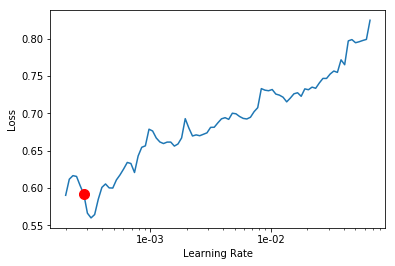

In [12]:
learn.unfreeze()
learn.lr_find(start_lr=slice(1e-5, 1e-4), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.570142,0.578886,0.795000,0.791843,01:18
1,0.535663,0.440824,0.812500,0.813176,01:18
2,0.465476,0.332808,0.900000,0.900105,01:18


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:189: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


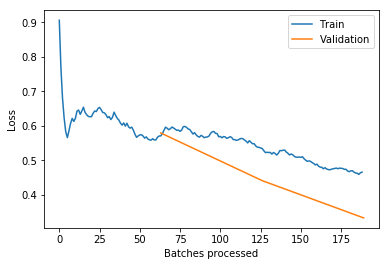

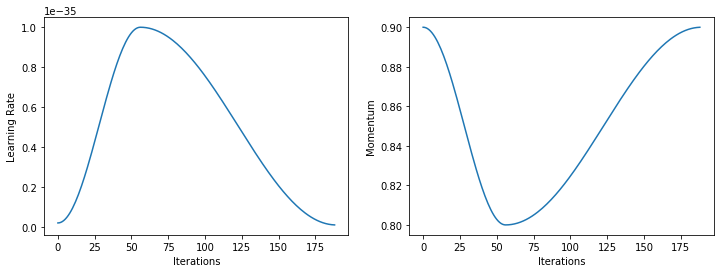

In [13]:
learn.fit_one_cycle(3, max_lr=slice(1e-4, 1e-35), div_factor=50, final_div=100, wd=1e-2, moms=(0.9, 0.8))
learn.save('201stage2-final')
learn.recorder.plot_losses()
# schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.506576,0.429717,0.862500,0.860312,01:18
1,0.371009,0.264055,0.917500,0.917626,01:18
2,0.306622,0.301621,0.882500,0.882887,01:18
3,0.244044,0.252604,0.910000,0.911121,01:18
4,0.201214,0.245387,0.917500,0.918081,01:18
5,0.191537,0.222400,0.922500,0.923119,01:18
6,0.132816,0.178975,0.945000,0.945241,01:18
7,0.105496,0.175293,0.947500,0.947731,01:18
8,0.075204,0.171475,0.950000,0.950167,01:18
9,0.064837,0.171434,0.955000,0.955092,01:18


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:189: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


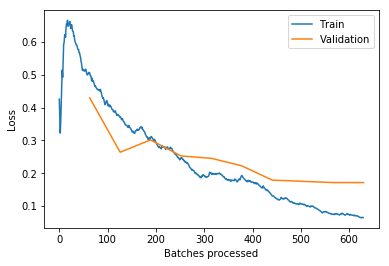

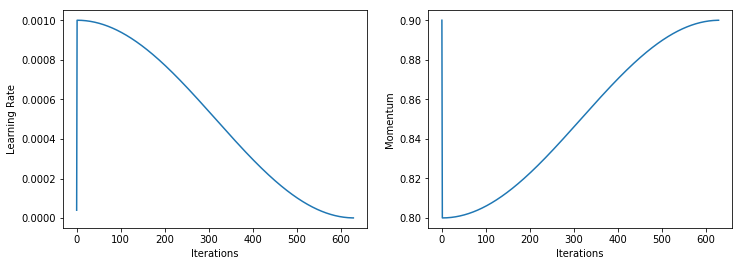

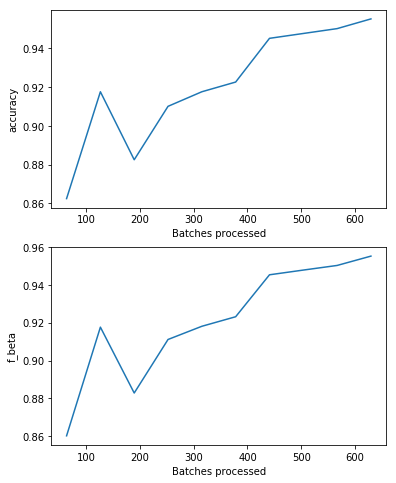

In [14]:
learn.fit_one_cycle(cyc_len=10, max_lr=slice(1e-4, 1e-3), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0
learn.save('201stage3-final')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

In [0]:
#save model
learn.save('d201-latest')

In [0]:
#interpret the training reults
learn.load('201stage3-final')
interp = ClassificationInterpretation.from_learner(learn)

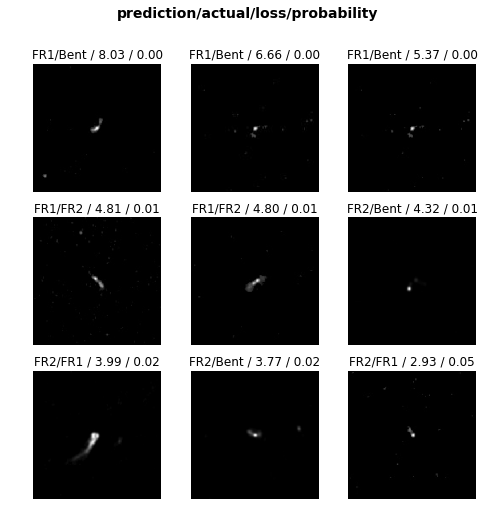

In [17]:
interp.plot_top_losses(9, figsize=(8,8))

In [16]:
interp.most_confused(min_val=2)

[('FR1', 'FR2', 6),
 ('FR2', 'FR1', 5),
 ('Bent', 'FR2', 3),
 ('Bent', 'FR1', 2),
 ('FR2', 'Bent', 2)]

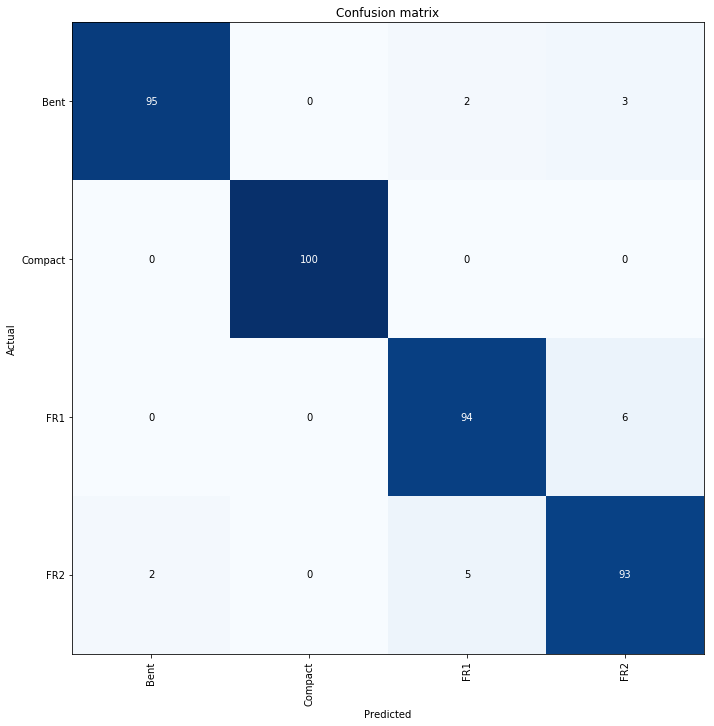

In [17]:
#get the results for the validation set
interp.plot_confusion_matrix(figsize=(10,10))

In [0]:
#export the model as pickle
learn.export('201stage3-final.pkl')

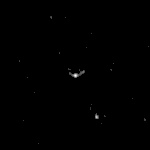

In [0]:
img = open_image('Final_rgdata/test/Bent/J003113.86+001236.2.jpeg')
img

In [0]:
#predict on a single image
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Bent

In [0]:
#optional : To optimize the model and parameter tuning
learn.lr_find()
learn.recorder.plot()

#Tweak the layers
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-3)) #based on the best learning rate

In [0]:
#Optional: Save the model again, if tweaked and optimized
learn.save('Final_d161')

In [0]:
#Optional: Export the better model if optimized
learn.export('Final_d161.pkl')

In [19]:
#Testing the model

path_img = Path('Final_rgdata')## Loading data 
#data = ImageDataBunch.from_folder(path=path_img, train='train', valid='valid', ds_tfms=get_transforms(),size=224, bs=bs), check_ext=False)## Normalizing data based on Image net parameters
data = ImageDataBunch.from_folder(path=path_img, train='train', valid='test', ds_tfms=get_transforms(),size=224, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (2024 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
FR2,FR2,FR2,FR2,FR2
Path: Final_rgdata;

Valid: LabelList (404 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bent,Bent,Bent,Bent,Bent
Path: Final_rgdata;

Test: None

In [0]:
#Get the architecture and reload the model weights
learn = cnn_learner(data, models.densenet201, metrics=[accuracy, FBeta()])

In [0]:
learn = learn.load('201stage3-final')

In [0]:
#interpret for the test data
interp = ClassificationInterpretation.from_learner(learn)

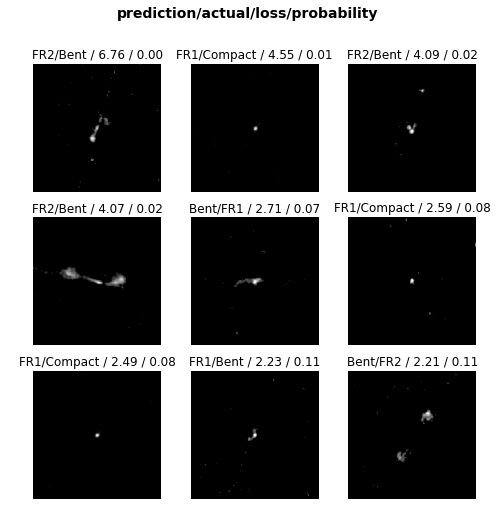

In [23]:
interp.plot_top_losses(9, figsize=(8,8))

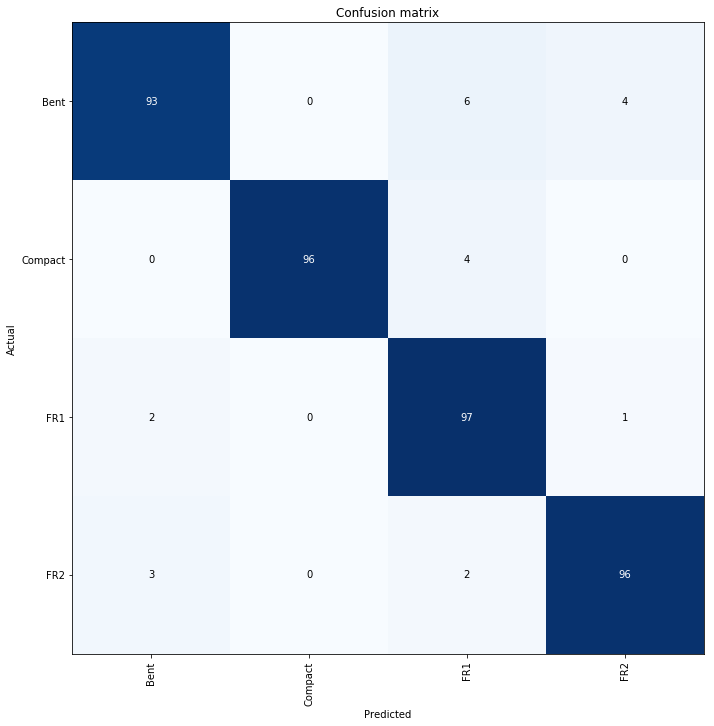

In [25]:
interp.plot_confusion_matrix(figsize=(10,10))

In [26]:
interp.most_confused(min_val=2)

[('Bent', 'FR1', 6),
 ('Bent', 'FR2', 4),
 ('Compact', 'FR1', 4),
 ('FR2', 'Bent', 3),
 ('FR1', 'Bent', 2),
 ('FR2', 'FR1', 2)]

In [0]:
learn.export('201stage-3.pkl')

In [27]:
import glob

image_list = glob.glob('Final_rgdata/test/*/*')

Bent = 0
Pred_Bent=0
Compact=0
Pred_Compact=0
FRI=0
Pred_FRI=0
FRII=0
Pred_FRII = 0 

for each in image_list:
    img = open_image(each)
    each = each.split('/')
    rg_class = each[2]
    pred_class, pred_idx, outputs = learn.predict(img)
    pred_class = str(pred_class)
         
    if rg_class == 'Bent':
        Bent += 1
        if pred_class == 'Bent':
            Pred_Bent += 1
    elif rg_class == 'Compact':
        Compact += 1
        if pred_class == 'Compact':
            Pred_Compact += 1
    elif rg_class == 'FR1':
        FRI += 1
        if pred_class == 'FR1':
            Pred_FRI += 1
    elif rg_class == 'FR2':
        FRII += 1
        if pred_class == 'FR2':
            Pred_FRII += 1
            
    
print('Bent accuracy: ' + str(Pred_Bent) + '/' + str(Bent))
print('Compact accuracy: ' + str(Pred_Compact) + '/' + str(Compact))
print('FR1 accuracy: ' + str(Pred_FRI) + '/' + str(FRI) )
print('FR2 accuracy: ' + str(Pred_FRII) + '/' + str(FRII) )

Bent accuracy: 93/103
Compact accuracy: 96/100
FR1 accuracy: 97/100
FR2 accuracy: 96/101
